In [2]:
import os
import pandas as pd
import matplotlib.dates as md
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import style
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

style.use('ggplot')
plt.rcParams['figure.figsize'] = (14,7)

In [3]:
def calculate_trial_means(folder):
    
    trials = os.listdir(directory + folder)
    differences = []

    for individual_trial in trials:
        if individual_trial == ".ipynb_checkpoints":
            continue
        current_path = directory + folder + "/" + individual_trial + "/"
        differences.append(results_individual_trial(current_path))
    
    differences_df = pd.DataFrame(differences)
    slope = differences_df['slope_diff'].agg(['mean', 'sem']).fillna(0).to_dict()
    tx_per_sec = differences_df['tx_per_sec'].agg(['mean', 'sem']).fillna(0).to_dict()
    
    mean_sem = {'mean_slope': round(slope['mean'], 4), 'mean_tx': round(tx_per_sec['mean'], 4)}
    return mean_sem


In [14]:
def results_individual_trial(current_path):
    global lost_transactions
    global changed_order_count
    
    # Submissions
    #print(current_path)
    submits = pd.read_json(path_or_buf=current_path + 'submits.json', convert_dates=False)
    start_time = submits['timestamp'].values[0]
    submits['timestamp'] = (submits['timestamp'] - start_time) / 1000
    submits = submits.drop(columns = ['txHash'])
    submits = submits.set_index('index')
    
    # Blocks
    global blocks
    blocks = pd.read_json(path_or_buf=current_path + 'blocks.json', convert_dates=False)
    blocks['timestamp'] = blocks['timestamp'] - start_time / 1000
    blocks.loc[-1] = [0, blocks['timestamp'].values[0]]
    blocks.shift(1)
    blocks.sort_index(inplace=True) 
    blocks = blocks.set_index('amountTx')
    
    # Linear regression
    # Submit slope
    x_submit = submits.timestamp.values.reshape(-1,1)
    y_submit = submits.index.values
    reg_submit = LinearRegression().fit(x_submit, y_submit)
    submit_slope = reg_submit.coef_
    
    # Blocks slope
    x_blocks = blocks.timestamp.values.reshape(-1,1)
    y_blocks = blocks.index.values
    reg_blocks = LinearRegression().fit(x_blocks, y_blocks)
    y_blocks_pred = reg_blocks.predict(x_blocks)

    
    slope_difference = abs((reg_blocks.coef_ / reg_submit.coef_) - 1)
    
    return {'tx_per_sec': reg_submit.coef_[0], 
            'slope_diff': slope_difference[0]}

In [18]:
global directory
directory = "results/ethereum/baseload_0/"

files = os.listdir(directory)

results_avg = pd.DataFrame(
    columns = ['mean_slope', 'mean_tx','trial_folder']
)

for sub_folder in files:
    if sub_folder == ".ipynb_checkpoints":
        continue
    mean_sem = calculate_trial_means(sub_folder)
    mean_sem['trial_folder'] = sub_folder
    results_avg = results_avg.append(mean_sem, ignore_index=True)
    
results_avg = results_avg.set_index('trial_folder')
results_avg = results_avg.sort_values(by=['mean_tx'])

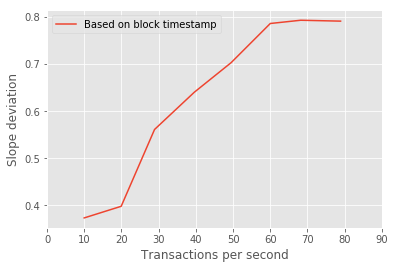

In [20]:
fig = plt.figure()
ax=fig.add_subplot(111)

ax.plot(results_avg['mean_tx'], results_avg['mean_slope'], label='Based on block timestamp', color='#EE442F')

ax.set_ylabel('Slope deviation')
ax.set_xlabel('Transactions per second')
ax.xaxis.set_ticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90])


plt.legend()
plt.show()